<a href="https://colab.research.google.com/github/obeabi/SdsNovember2020Challenge/blob/main/Main_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS October Challenge #3 - Fraudulent Job Adverts
## 2021-01-22

### Using RANDOM Forest ALGORTHIM

## Problem Statement
Welcome Data Scientist to the 3rd SDS Club Monthly Challenge! In this month’s challenge you are helping your friend search for a job. Your friend has found thousands of job ads online and is trying to pick some to apply to. Your friends has heard that there are a lot of fraudulent job ads that are actually scams. Your mission is to help your friend by predicting whether a job is fraudulent based on the data provided.

In [109]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
!pip install imbalanced-learn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

np.random.seed(0)

Libraries installed successfully!


In [110]:
# Importing the dataset and check the shape and total number of missing values

df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

df_train.head()

,telecommuting,has_company_logo,has_questions,fraudulent,department_ind,salary_range_ind,company_profile_ind,description_ind,requirements_ind,benefits_ind,employment_type_ind,required_experience_ind,required_education_ind,industry_ind,function_ind
0,0,1,1,0,1,1,1,1,0,0,1,1,0,1,1
1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1
2,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1
3,0,0,0,1,0,1,0,1,0,0,1,1,1,1,1
4,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1


In [111]:
# print column names
print(df_train.columns)
print(df_train.shape)

Index(['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent',
       'department_ind', 'salary_range_ind', 'company_profile_ind',
       'description_ind', 'requirements_ind', 'benefits_ind',
       'employment_type_ind', 'required_experience_ind',
       'required_education_ind', 'industry_ind', 'function_ind'],
      dtype='object')
(14304, 15)


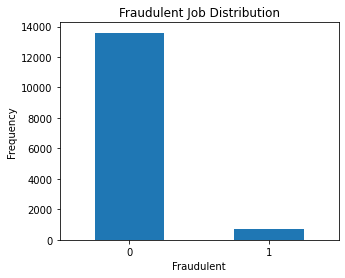

In [112]:
# Let's visualize the distribution of data
count_classes = pd.value_counts(df_train['fraudulent'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title("Fraudulent Job Distribution")
plt.xticks(range(2))
plt.xlabel("Fraudulent")
plt.ylabel('Frequency')
plt.show()

In [113]:
# gET THE CANCELLED AND NOT CANCEELED FLIFGTS
Fraud = df_train[df_train['fraudulent']== 1]
notFraud = df_train[df_train['fraudulent']== 0]

print(Fraud.shape, notFraud.shape)

(709, 15) (13595, 15)


In [114]:
# Extract features and target from train set dataframe and perform standard scaling
X = df_train.drop(columns = ['fraudulent'])
y = df_train['fraudulent']

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif


,vif,Features
0,1.015037,telecommuting
1,2.231826,has_company_logo
2,1.147619,has_questions
3,1.091452,department_ind
4,1.126374,salary_range_ind
5,2.043819,company_profile_ind
6,1.000841,description_ind
7,1.366703,requirements_ind
8,1.332157,benefits_ind
9,2.202904,employment_type_ind


In [144]:
# Extract features and target from train set dataframe
#y = df_train.fraudulent.values.ravel()
#X = df_train.drop(columns= ['fraudulent'], axis = 1)

X_scaled

array([[-0.21339542,  0.508746  ,  1.01450678, ..., -1.1008382 ,
         0.61225471,  0.75120201],
       [-0.21339542,  0.508746  ,  1.01450678, ..., -1.1008382 ,
         0.61225471,  0.75120201],
       [-0.21339542,  0.508746  ,  1.01450678, ...,  0.90839871,
         0.61225471,  0.75120201],
       ...,
       [-0.21339542,  0.508746  ,  1.01450678, ...,  0.90839871,
         0.61225471,  0.75120201],
       [-0.21339542,  0.508746  , -0.98570066, ..., -1.1008382 ,
        -1.63330717, -1.33119984],
       [-0.21339542,  0.508746  ,  1.01450678, ..., -1.1008382 ,
        -1.63330717, -1.33119984]])

In [145]:
# print first five rows target column
y[0:5]

0    0
1    0
2    0
3    1
4    0
Name: fraudulent, dtype: int64

In [148]:
# Split data to train and test set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2, random_state=0)

# Display train set
X_train

array([[-0.21339542,  0.508746  , -0.98570066, ...,  0.90839871,
         0.61225471,  0.75120201],
       [-0.21339542,  0.508746  ,  1.01450678, ..., -1.1008382 ,
         0.61225471,  0.75120201],
       [-0.21339542, -1.96561741,  1.01450678, ..., -1.1008382 ,
        -1.63330717, -1.33119984],
       ...,
       [-0.21339542,  0.508746  ,  1.01450678, ...,  0.90839871,
         0.61225471, -1.33119984],
       [-0.21339542,  0.508746  ,  1.01450678, ...,  0.90839871,
         0.61225471,  0.75120201],
       [-0.21339542,  0.508746  ,  1.01450678, ...,  0.90839871,
         0.61225471,  0.75120201]])

### Model 1: Train Model Directly (disregarding imbalanced nature of dataset

In [149]:
# Train Random Forest Classifier
class_weight=dict({0:1,1:19})

# Function for results
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [150]:
# Train model
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier( class_weight=class_weight)
classifier


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 19}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [151]:
# Perform K-Fold CV and hyperparameter tuning
parameters = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy']
}

cv = GridSearchCV(classifier, parameters, cv=5)
cv.fit(X_train, y_train)

print_results(cv)

BEST PARAMS: {'criterion': 'gini', 'n_estimators': 100}

0.868 (+/-0.009) for {'criterion': 'gini', 'n_estimators': 100}
0.856 (+/-0.042) for {'criterion': 'gini', 'n_estimators': 200}
0.858 (+/-0.043) for {'criterion': 'gini', 'n_estimators': 500}
0.868 (+/-0.01) for {'criterion': 'entropy', 'n_estimators': 100}
0.857 (+/-0.047) for {'criterion': 'entropy', 'n_estimators': 200}
0.857 (+/-0.043) for {'criterion': 'entropy', 'n_estimators': 500}


In [152]:
# Save best model
model_1 = cv.best_estimator_
model_1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 19}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [153]:
# Make prediction and print metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score
y_pred=model_1.predict(X_valid)
y_pred_proba = model_1.predict_proba(X_valid)
print( confusion_matrix(y_valid,y_pred))
print("The accuracy score is :", accuracy_score(y_valid,y_pred))
print( classification_report(y_valid,y_pred))
print("The roc_auc_score is :",roc_auc_score(y_valid, model_1.predict_proba(X_valid)[:, 1]) )

[[2356  370]
 [  37   98]]
The accuracy score is : 0.8577420482348829
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      2726
           1       0.21      0.73      0.33       135

    accuracy                           0.86      2861
   macro avg       0.60      0.80      0.62      2861
weighted avg       0.95      0.86      0.89      2861

The roc_auc_score is : 0.8720714111029593


In [159]:
y_result = y_valid.values.ravel()
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_result.reshape(len(y_result),1)),1))


[[1 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


### Model 2: Random Oversampling

In [160]:
# Random Oversampling method
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
os=RandomOverSampler(0.75)
X_os,y_os=os.fit_sample(X_scaled, y)

print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_os)))

The number of classes before fit Counter({0: 10869, 1: 574})
The number of classes after fit Counter({0: 13595, 1: 10196})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [162]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train_os, X_valid_os, y_train_os, y_valid_os = train_test_split(X_os, y_os,train_size=0.8, test_size=0.2, random_state=0)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier2=RandomForestClassifier()
# Perform K-Fold CV and hyperparameter tuning
parameters = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy']
}

cv2 = GridSearchCV(classifier2, parameters, cv=5)
cv2.fit(X_train_os, y_train_os)

print_results(cv2)

BEST PARAMS: {'criterion': 'gini', 'n_estimators': 200}

0.845 (+/-0.013) for {'criterion': 'gini', 'n_estimators': 100}
0.845 (+/-0.015) for {'criterion': 'gini', 'n_estimators': 200}
0.845 (+/-0.016) for {'criterion': 'gini', 'n_estimators': 500}
0.845 (+/-0.014) for {'criterion': 'entropy', 'n_estimators': 100}
0.845 (+/-0.014) for {'criterion': 'entropy', 'n_estimators': 200}
0.845 (+/-0.016) for {'criterion': 'entropy', 'n_estimators': 500}


In [163]:
# Save best model
model_2 = cv2.best_estimator_
model_2

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [164]:
# Make prediction and print metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score
y_pred=model_2.predict(X_valid_os)
y_pred_proba = model_2.predict_proba(X_valid_os)
print( confusion_matrix(y_valid_os,y_pred))
print("The accuracy score is :", accuracy_score(y_valid_os,y_pred))
print( classification_report(y_valid_os,y_pred))
print("The roc_auc_score is :",roc_auc_score(y_valid_os, model_2.predict_proba(X_valid_os)[:, 1]) )

[[2360  369]
 [ 339 1691]]
The accuracy score is : 0.8512292498424039
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2729
           1       0.82      0.83      0.83      2030

    accuracy                           0.85      4759
   macro avg       0.85      0.85      0.85      4759
weighted avg       0.85      0.85      0.85      4759

The roc_auc_score is : 0.9303519757683845


In [166]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_valid_os.reshape(len(y_valid_os),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [0 0]]


### Model 3: SMOTEK

In [167]:
# Oversampling method 
# Class to perform over-sampling using SMOTE and cleaning using Tomek links.

from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=0)
X_sm,y_sm = smk.fit_sample(X_scaled,y)

# Inspect resampled dataset
from collections import Counter
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_sm))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 13595, 1: 709})
Resampled dataset shape Counter({0: 13595, 1: 13595})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [168]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train_sm, X_valid_sm, y_train_sm, y_valid_sm = train_test_split(X_sm, y_sm,train_size=0.8, test_size=0.2, random_state=0)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier3=RandomForestClassifier()
# Perform K-Fold CV and hyperparameter tuning
parameters = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy']
}

cv3 = GridSearchCV(classifier3, parameters, cv=5)
cv3.fit(X_train_sm, y_train_sm)

print_results(cv3)

BEST PARAMS: {'criterion': 'entropy', 'n_estimators': 100}

0.877 (+/-0.01) for {'criterion': 'gini', 'n_estimators': 100}
0.877 (+/-0.01) for {'criterion': 'gini', 'n_estimators': 200}
0.877 (+/-0.01) for {'criterion': 'gini', 'n_estimators': 500}
0.877 (+/-0.01) for {'criterion': 'entropy', 'n_estimators': 100}
0.877 (+/-0.01) for {'criterion': 'entropy', 'n_estimators': 200}
0.877 (+/-0.011) for {'criterion': 'entropy', 'n_estimators': 500}


In [169]:
# Save best model
model_3 = cv3.best_estimator_
model_3

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
# Make prediction and print metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score
y_pred=model_3.predict(X_valid_sm)
y_pred_proba = model_3.predict_proba(X_valid_sm)
print( confusion_matrix(y_valid_sm,y_pred))
print("The accuracy score is :", accuracy_score(y_valid_sm,y_pred))
print( classification_report(y_valid_sm,y_pred))
print("The roc_auc_score is :",roc_auc_score(y_valid_sm, model_3.predict_proba(X_valid_sm)[:, 1]) )

[[2412  247]
 [ 381 2398]]
The accuracy score is : 0.8845163663111438
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      2659
           1       0.91      0.86      0.88      2779

    accuracy                           0.88      5438
   macro avg       0.89      0.89      0.88      5438
weighted avg       0.89      0.88      0.88      5438

The roc_auc_score is : 0.9566177643777318


In [171]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_valid_sm.reshape(len(y_valid_sm),1)),1))

[[1 1]
 [0 0]
 [0 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


### Model 4: Under Sampling

In [172]:
# Undersampling method 
from collections import Counter
from imblearn.under_sampling import NearMiss
ns=NearMiss(0.8)
X_ns,y_ns=ns.fit_sample(X_scaled,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


The number of classes before fit Counter({0: 13595, 1: 709})
The number of classes after fit Counter({0: 886, 1: 709})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [173]:
# Break off validation set from training data
from sklearn.model_selection import train_test_split
X_train_ns, X_valid_ns, y_train_ns, y_valid_ns = train_test_split(X_ns, y_ns,train_size=0.8, test_size=0.2, random_state=0)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
classifier4=RandomForestClassifier()

# Perform K-Fold CV and hyperparameter tuning
parameters = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy']
}

cv4 = GridSearchCV(classifier4, parameters, cv=5)
cv4.fit(X_train_ns, y_train_ns)

print_results(cv4)

BEST PARAMS: {'criterion': 'gini', 'n_estimators': 500}

0.81 (+/-0.049) for {'criterion': 'gini', 'n_estimators': 100}
0.811 (+/-0.05) for {'criterion': 'gini', 'n_estimators': 200}
0.814 (+/-0.046) for {'criterion': 'gini', 'n_estimators': 500}
0.807 (+/-0.05) for {'criterion': 'entropy', 'n_estimators': 100}
0.812 (+/-0.049) for {'criterion': 'entropy', 'n_estimators': 200}
0.809 (+/-0.052) for {'criterion': 'entropy', 'n_estimators': 500}


In [174]:
# Save best model
model_4 = cv4.best_estimator_
model_4

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [175]:
# Make prediction and print metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,roc_auc_score
y_pred=model_4.predict(X_valid_ns)
y_pred_proba = model_4.predict_proba(X_valid_ns)
print( confusion_matrix(y_valid_ns,y_pred))
print("The accuracy score is :", accuracy_score(y_valid_ns,y_pred))
print( classification_report(y_valid_ns,y_pred))
print("The roc_auc_score is :",roc_auc_score(y_valid_ns, model_4.predict_proba(X_valid_ns)[:, 1]) )

[[159  15]
 [ 51  94]]
The accuracy score is : 0.7931034482758621
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       174
           1       0.86      0.65      0.74       145

    accuracy                           0.79       319
   macro avg       0.81      0.78      0.78       319
weighted avg       0.80      0.79      0.79       319

The roc_auc_score is : 0.8552516845025763


In [176]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_valid_ns.reshape(len(y_valid_ns),1)),1))

[[0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 1]

### Save best Random Forest Model


In [177]:
# Save model as a pickle file
import pickle
filename = 'random_forest.pickle'
pickle.dump(model_3, open(filename, 'wb'))   # accuracy = 0.885, roc_auc_score = 0.957

### KFold validation on best model

In [178]:
#k-fold cross validation 
kfold = KFold(n_splits=12,random_state= 42)
kfold.get_n_splits(X)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


12

In [179]:
# Perform kfold cv
from statistics import mean
clf =model_3
cnt =0
count=[]
train_score =[]
valid_score = []

for train_index,valid_index in kfold.split(X_scaled):
    X_train, X_valid = X_scaled[train_index], X_scaled[valid_index] # our scaled data is an array so it can work on x[value]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index] # y is a dataframe so we have to use "iloc" to retreive data
    clf.fit(X_train,y_train)
    train_score_ = clf.score(X_train,y_train)
    valid_score_ =  clf.score(X_valid,y_valid)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    valid_score.append(valid_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and valid score is :  ", valid_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average valid score is :  ", mean(valid_score))

for k =  1
train_score is :   0.9596552776082977 and valid score is :   0.9538590604026845
for k =  2
train_score is :   0.9595790115924344 and valid score is :   0.9530201342281879
for k =  3
train_score is :   0.9601128737034778 and valid score is :   0.950503355704698
for k =  4
train_score is :   0.9588926174496645 and valid score is :   0.9588926174496645
for k =  5
train_score is :   0.9593502135448444 and valid score is :   0.9580536912751678
for k =  6
train_score is :   0.9590451494813911 and valid score is :   0.9614093959731543
for k =  7
train_score is :   0.9589688834655278 and valid score is :   0.9572147651006712
for k =  8
train_score is :   0.9590451494813911 and valid score is :   0.959731543624161
for k =  9
train_score is :   0.9600366076876145 and valid score is :   0.950503355704698
for k =  10
train_score is :   0.9591976815131178 and valid score is :   0.9572147651006712
for k =  11
train_score is :   0.9598840756558877 and valid score is :   0.9496644295302014


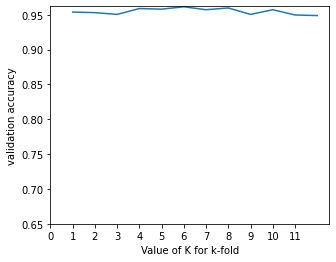

In [180]:
# let's plot the test_accuracy with the value of k in k-fold

plt.plot(count,valid_score)
plt.xlabel('Value of K for k-fold')
plt.ylabel('validation accuracy')
plt.xticks(np.arange(0, 12, 1)) 
plt.yticks(np.arange(0.65, 1, 0.05)) 
plt.show()

## Make prediction on test set with best model

In [181]:
# Best model was obtained with random over sampling method
column_names = X.columns
dataset_test = df_test[column_names]

dataset_test.head()

,telecommuting,has_company_logo,has_questions,department_ind,salary_range_ind,company_profile_ind,description_ind,requirements_ind,benefits_ind,employment_type_ind,required_experience_ind,required_education_ind,industry_ind,function_ind
0,0,1,1,1,0,1,1,1,1,1,1,0,1,0
1,0,1,1,1,0,1,1,1,1,1,1,0,0,1
2,0,0,0,0,1,1,1,0,0,1,1,1,1,1
3,0,0,0,1,0,0,1,1,1,0,0,0,0,0
4,0,1,0,0,0,1,1,1,0,1,1,1,1,1


In [182]:
# Make prediction
X_test = dataset_test.values
X_test = scalar.transform(X_test)

loaded_model = pickle.load(open('random_forest.pickle', 'rb'))
y_hat = loaded_model.predict(X_test)
y_hat

array([0, 0, 0, ..., 1, 0, 0])

In [183]:
 # Save Numpy array to csv with custom header and footer
np.savetxt('random_forest_20210124.csv', y_hat, delimiter=',', fmt='%d' , header='Result:: Header', footer='This is footer')